In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [79]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 15

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"
SIDES_DIR = BASE_DIR / "interm/sides"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_FEATURES.pkl"

## Loading Data

In [80]:
%%time
df = pd.read_pickle(RESAMPLED_FILE_PATH)

CPU times: user 1.8 ms, sys: 7.78 ms, total: 9.58 ms
Wall time: 7.85 ms


In [81]:
df.shape

(99724, 7)

In [82]:
df.head()

,timestamp,open,high,low,close,volume,spread
0,2021-01-03 22:00:00,103.1185,103.2435,103.1175,103.2280,1.058100e+11,0.025971
1,2021-01-03 22:15:00,103.2230,103.2615,103.2180,103.2380,1.543600e+11,0.016620
2,2021-01-03 22:30:00,103.2385,103.2470,103.1905,103.2080,4.885000e+11,0.026133
3,2021-01-03 22:45:00,103.2075,103.2355,103.2025,103.2215,3.819300e+11,0.033980
4,2021-01-03 23:00:00,103.2220,103.2740,103.2085,103.2650,3.547530e+12,0.013600


In [83]:
df["timestamp"] = df["timestamp"].astype("datetime64[s]")
df = df.set_index("timestamp")
df = df.dropna()

## Calculating Donchian

In [84]:
def donchian_breakout(ohlc: pd.DataFrame, lookback: int):
    # input df is assumed to have a 'close' column
    upper = ohlc['close'].rolling(lookback - 1).max().shift(1)
    lower = ohlc['close'].rolling(lookback - 1).min().shift(1)
    signal = pd.Series(np.full(len(ohlc), np.nan), index=ohlc.index)
    signal.loc[ohlc['close'] > upper] = 1
    signal.loc[ohlc['close'] < lower] = -1
    signal = signal.ffill()
    return signal

In [85]:
def optimize_donchian(ohlc: pd.DataFrame):

    best_pf = 0
    best_lookback = -1
    r = np.log(ohlc['close']).diff().shift(-1)
    for lookback in range(12, 180):
        signal = donchian_breakout(ohlc, lookback)
        sig_rets = signal * r
        sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()

        if sig_pf > best_pf:
            best_pf = sig_pf
            best_lookback = lookback

    return best_lookback, best_pf

In [86]:
lookback, pf = optimize_donchian(df)
print('best lookback:', lookback)
print('best pf:', pf)

best lookback: 54
best pf: 1.0218015883376061


# Reproduce the strategy with optimized parameters

Profit Factor 54 1.0218015883376061


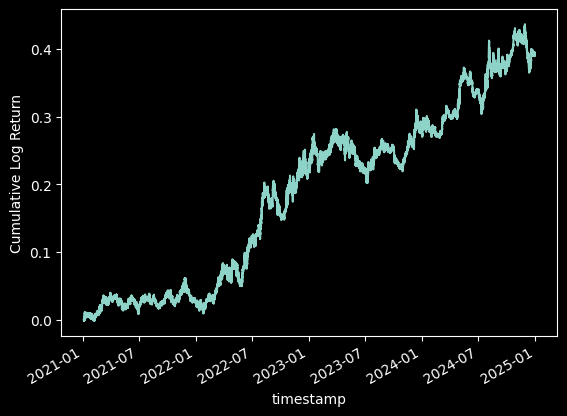

In [87]:
df['signal'] = donchian_breakout(df, lookback)
df["r"] = np.log(df["close"]).diff().shift(-1)
strat_r = df["signal"] * df["r"]

pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
print("Profit Factor", lookback, pf)

plt.style.use("dark_background")
strat_r.cumsum().plot()
plt.ylabel("Cumulative Log Return")
plt.show()

In [88]:
df['signal'].value_counts()

signal
 1.0    54797
-1.0    44859
Name: count, dtype: int64

In [89]:
# find crossover events
t_events = df.index[df['signal'] != df['signal'].shift(1)]
t_events

DatetimeIndex(['2021-01-03 22:00:00', '2021-01-03 22:15:00',
               '2021-01-03 22:30:00', '2021-01-03 22:45:00',
               '2021-01-03 23:00:00', '2021-01-03 23:15:00',
               '2021-01-03 23:30:00', '2021-01-03 23:45:00',
               '2021-01-04 00:00:00', '2021-01-04 00:15:00',
               ...
               '2024-12-18 12:45:00', '2024-12-20 06:00:00',
               '2024-12-23 07:00:00', '2024-12-24 04:00:00',
               '2024-12-24 14:30:00', '2024-12-25 02:00:00',
               '2024-12-25 05:15:00', '2024-12-27 02:00:00',
               '2024-12-27 19:30:00', '2024-12-30 11:15:00'],
              dtype='datetime64[s]', name='timestamp', length=1242, freq=None)

## Labeling Sides

黃金交叉與死亡交叉

In [90]:
sides = pd.Series(df['signal'].loc[t_events], index=t_events, name='side')
sides.dropna(inplace=True)
sides

timestamp
2021-01-04 15:00:00    1.0
2021-01-05 04:00:00   -1.0
2021-01-06 09:30:00    1.0
2021-01-08 13:30:00   -1.0
2021-01-10 23:30:00    1.0
                      ... 
2024-12-25 02:00:00   -1.0
2024-12-25 05:15:00    1.0
2024-12-27 02:00:00   -1.0
2024-12-27 19:30:00    1.0
2024-12-30 11:15:00   -1.0
Name: side, Length: 1174, dtype: float64

In [91]:
sides.value_counts()

side
 1.0    587
-1.0    587
Name: count, dtype: int64

## Saving to disk

In [92]:
SIDE_NAME = f"donchian_breakout_{lookback}"

In [93]:
SIDE_FILE_PATH = SIDES_DIR / f"{RESAMPLED_NAME}-{SIDE_NAME}.pkl"
SIDE_FILE_PATH

PosixPath('../data/interm/sides/USDJPY-15m-20210101-20241231-donchian_breakout_54.pkl')

In [94]:
sides.to_pickle(SIDE_FILE_PATH)